In [1]:
import dandelion as ddl
import pandas as pd
import scanpy as sc
import anndata as ad
import muon as mu
import mudata as md
from mudata import MuData
import numpy as np
import warnings
import os

import scirpy as ir
from cycler import cycler

from matplotlib import cm as mpl_cm
from matplotlib import pyplot as plt

from palmotif import compute_motif, svg_logo
import seaborn as sb
warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore")
ddl.logging.print_header()

# Desactivar todos los warnings
warnings.filterwarnings("ignore")

# Opcional: Desactivar warnings específicos (ejemplo: FutureWarnings de anndata)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)

# Si usas tqdm y deseas evitar sus warnings
from tqdm import TqdmWarning
warnings.simplefilter(action="ignore", category=TqdmWarning)

/home/evercher/miniforge3/envs/dandelion/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/evercher/miniforge3/envs/dandelion/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/evercher/miniforge3/envs/dandelion/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/evercher/miniforge3/envs/dandelion/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/evercher/miniforge3/envs/dandelion/lib/python3.11/site-packages/anndata/util

dandelion==0.5.0 pandas==2.2.3 numpy==2.0.2 matplotlib==3.9.3 networkx==3.4.2 scipy==1.14.1


## Vamos con KNN a ver si podemos anotar los NA de los TIL del ATLAS:

In [2]:
import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from pynndescent import PyNNDescentTransformer


In [3]:
# Cargar el objeto MuData
mdata_file = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/05_datos_integrados/mudata_harmony_conTCR.h5mu"
mdata = mu.read(mdata_file)

In [4]:
mdata

MuData object with n_obs × n_vars = 49043 × 23209
  2 modalities
    gex:	49043 x 23209
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'prediction', 'doublet', 'doublet_filtered', 'Sample', 'n_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'hvg', 'log1p', 'neighbors'
      obsm:	'X_pca_harmony', 'X_umap'
      layers:	'counts_soupx_crude', 'original_counts'
      obsp:	'connectivities', 'distances'
    airr:	49043 x 0
      obs:	'sample', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size', 'clonal_expansion', 'clone_id_freq', 'FirmaCimaPlus_FINAL ', 'FirmaCima_FINAL ', 'Firma_Oliveira_FINAL ', 'Lowery_Patente-2_FINAL(CD8) ', 'Lowery_Patente_FINAL(CD8) ', 'Petremand_FINAL ', 'Lowery_ALL_FINAL', 'ATLAS_TIL', 'ATLAS_TIL_score', 'Celltypist', 'Celltypist_score', 'pgen_cdr3_b_aa_nlog10_z', 'pgen_cdr3_a_aa_nlog10_z'
      uns:	'chain_indices', 'clone_id', 'ir_dist_nt_identity'
      obsm:	'airr', 'chain_indices'

In [5]:
# Seleccionar la modalidad 'gex' (expresión génica)
adata_gex = mdata.mod['gex'].copy()
adata_gex.obs['ATLAS_TIL'] = mdata.mod['airr'].obs['ATLAS_TIL']
adata_gex.obs['ATLAS_TIL_score'] = mdata.mod['airr'].obs['ATLAS_TIL_score']
adata_gex.obs['Celltypist'] = mdata.mod['airr'].obs['Celltypist']
adata_gex.obs['Celltypist_score'] = mdata.mod['airr'].obs['Celltypist_score']

In [6]:
# Células etiquetadas (sin NaN en ATLAS_TIL)
labeled_cells = adata_gex.obs[~adata_gex.obs['ATLAS_TIL'].isna()]

# Células no etiquetadas (con NaN en ATLAS_TIL)
unlabeled_cells = adata_gex.obs[adata_gex.obs['ATLAS_TIL'].isna()]

print(f"Total de células etiquetadas: {labeled_cells.shape[0]}")
print(f"Total de células no etiquetadas (para KNN): {unlabeled_cells.shape[0]}")

Total de células etiquetadas: 44886
Total de células no etiquetadas (para KNN): 4157


In [7]:
def predict_knn_harmony(adata, embedding_key='X_pca_harmony', label_key='ATLAS_TIL', result_key='ATLAS_TIL_KNN', n_neighbors=15, weights='uniform'):
    """
    Predice los tipos celulares usando KNN sobre los datos integrados con Harmony.

    Parámetros:
    ----------
    adata : AnnData
        Objeto Anndata con los datos integrados por Harmony.
    embedding_key : str
        Clave en obsm para la matriz PCA integrada por Harmony.
    label_key : str
        Columna en obs que contiene las etiquetas de los datos etiquetados (ATLAS_TIL).
    result_key : str
        Clave donde se almacenarán las predicciones del KNN.
    n_neighbors : int
        Número de vecinos a considerar en el clasificador KNN.
    weights : str
        Estrategia de ponderación ('uniform' o 'distance') para el clasificador KNN.

    Retorna:
    -------
    Actualiza adata.obs con la columna `result_key` (ATLAS_TIL_KNN).
    """

    # Células etiquetadas y no etiquetadas
    labeled_mask = ~adata.obs[label_key].isna()
    unlabeled_mask = adata.obs[label_key].isna()

    # Datos de entrenamiento (etiquetados)
    X_train = adata.obsm[embedding_key][labeled_mask]
    y_train = adata.obs.loc[labeled_mask, label_key]

    # Datos para predecir (sin etiquetas)
    X_unlabeled = adata.obsm[embedding_key][unlabeled_mask]

    # Pipeline con PyNNDescent para optimización de vecinos más cercanos
    knn_pipeline = make_pipeline(
        PyNNDescentTransformer(n_neighbors=n_neighbors, n_jobs=-1),
        KNeighborsClassifier(metric='precomputed', weights=weights)
    )

    # Ajuste del modelo
    knn_pipeline.fit(X_train, y_train)

    # Predicción
    predictions = knn_pipeline.predict(X_unlabeled)

    # Guardar predicciones en una nueva columna
    adata.obs[result_key] = adata.obs[label_key]  # Copia la columna original
    adata.obs.loc[unlabeled_mask, result_key] = predictions  # Anota solo las células sin etiqueta

    print(f"✅ Predicción completada. Resultados guardados en '{result_key}'.")

# Ejecución de la función
predict_knn_harmony(adata_gex)

✅ Predicción completada. Resultados guardados en 'ATLAS_TIL_KNN'.


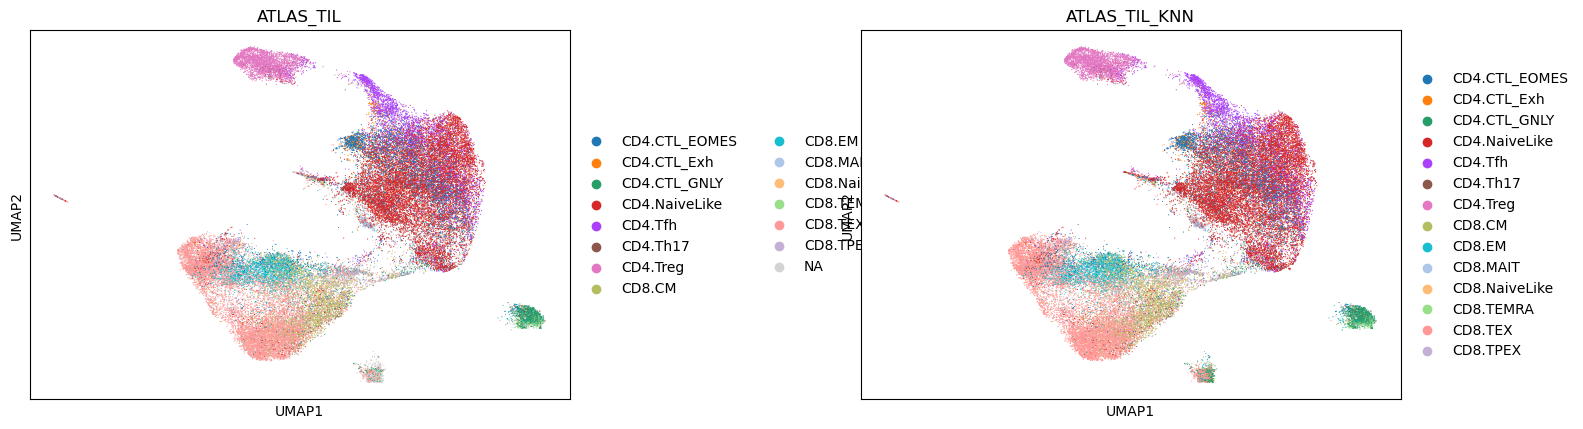

In [8]:
# Comparar visualmente las etiquetas originales y las predicciones del KNN
sc.pl.umap(adata_gex, color=['ATLAS_TIL', 'ATLAS_TIL_KNN'], wspace=0.4)

In [9]:
# Filtrar solo las células que originalmente tenían NaN en 'ATLAS_TIL'
nan_cells = adata_gex.obs[adata_gex.obs['ATLAS_TIL'].isna()]

# Crear la tabla con las columnas deseadas
result_table = nan_cells[['ATLAS_TIL', 'ATLAS_TIL_KNN', 'Celltypist', 'Celltypist_score']]

# Calcular los porcentajes de las categorías predichas por KNN
knn_category_percentages = result_table['ATLAS_TIL_KNN'].value_counts(normalize=True) * 100

# Calcular los porcentajes de las categorías en 'Celltypist'
celltypist_category_percentages = result_table['Celltypist'].value_counts(normalize=True) * 100


In [10]:
result_table

ATLAS_TIL  ATLAS_TIL_KNN                   Celltypist  \
AAACGGGCACCAGTTA-1_PT14       NaN       CD4.Treg           Regulatory T cells   
AAACGGGGTGAAATCA-1_PT14       NaN  CD4.CTL_EOMES    Tem/Trm cytotoxic T cells   
AAAGCAAGTCATGCAT-1_PT14       NaN  CD8.NaiveLike    Tem/Trm cytotoxic T cells   
AAAGTAGAGGCGCTCT-1_PT14       NaN         CD8.EM          gamma-delta T cells   
AACCATGGTCAGAAGC-1_PT14       NaN         CD8.EM    Tem/Trm cytotoxic T cells   
...                           ...            ...                          ...   
TTTGCGCTCGGTTCGG-1_PT50       NaN        CD8.TEX       Type 17 helper T cells   
TTTGGTTAGGTCATCT-1_PT50       NaN        CD8.TEX  Tem/Temra cytotoxic T cells   
TTTGTCAAGTACGTAA-1_PT50       NaN  CD4.NaiveLike  Tem/Effector helper T cells   
TTTGTCACAATGAAAC-1_PT50       NaN         CD8.EM  Tem/Temra cytotoxic T cells   
TTTGTCATCGTGGGAA-1_PT50       NaN   CD4.CTL_GNLY  Tem/Temra cytotoxic T cells   

                         Celltypist_score  
AAACGGGCACCAGTTA-1_PT14          0.743434  
AAACGGGGTGAAATCA-1_PT14          0.939469  
AAAGCAAGTCATGCAT-1_PT14          0.536620  
AAAGTAGAGGCGCTCT-1_PT14          0.947078  
AACCATGGTCAGAAGC-1_PT14          0.991423  
...                                   ...  
TTTGCGCTCGGTTCGG-1_PT50          0.018659  
TTTGGTTAGGTCATCT-1_PT50          0.264343  
TTTGTCAAGTACGTAA-1_PT50          0.583939  
TTTGTCACAATGAAAC-1_PT50          0.749133  
TTTGTCATCGTGGGAA-1_PT50          0.927800  

[4157 rows x 4 columns]

In [11]:
knn_category_percentages

ATLAS_TIL_KNN
CD8.TEX          38.657686
CD4.NaiveLike    25.932163
CD4.CTL_GNLY      7.794082
CD8.CM            6.278566
CD4.Tfh           5.244166
CD8.EM            4.690883
CD4.CTL_EOMES     4.089488
CD4.Treg          1.900409
CD8.TPEX          1.683907
CD8.TEMRA         1.515516
CD4.CTL_Exh       0.866009
CD8.MAIT          0.721674
CD4.Th17          0.408949
CD8.NaiveLike     0.216502
Name: proportion, dtype: float64

In [12]:
celltypist_category_percentages

Celltypist
Tem/Trm cytotoxic T cells      31.681501
Tem/Temra cytotoxic T cells    24.464758
Tem/Effector helper T cells    15.924946
gamma-delta T cells             8.154919
Type 1 helper T cells           6.446957
Regulatory T cells              6.062064
Tcm/Naive helper T cells        3.872985
Type 17 helper T cells          1.948521
MAIT cells                      1.250902
CD16+ NK cells                  0.096223
Memory B cells                  0.048112
CD16- NK cells                  0.048112
Name: proportion, dtype: float64

In [13]:
# Filtrar las células que originalmente eran NaN en 'ATLAS_TIL'
nan_cells = adata_gex.obs[adata_gex.obs['ATLAS_TIL'].isna()]

# Crear una tabla de contingencia entre 'ATLAS_TIL_KNN' y 'Celltypist'
contingency_table = pd.crosstab(nan_cells['ATLAS_TIL_KNN'], nan_cells['Celltypist'])

# Calcular el promedio de 'Celltypist_score' para cada combinación
mean_scores = nan_cells.groupby(['ATLAS_TIL_KNN', 'Celltypist'])['Celltypist_score'].mean().unstack(fill_value=0)

# Combinar la tabla de contingencia con los promedios de score
result_table = contingency_table.astype(str) + ' (' + mean_scores.round(2).astype(str) + ')'

# Filtrar para mostrar solo las combinaciones con valores mayores a 0
result_table = result_table[(contingency_table > 0).any(axis=1)]
result_table = result_table.loc[:, (contingency_table > 0).any(axis=0)]

In [14]:
result_table

Celltypist    CD16+ NK cells CD16- NK cells MAIT cells Memory B cells  \
ATLAS_TIL_KNN                                                           
CD4.CTL_EOMES        0 (nan)        0 (nan)    0 (nan)        0 (nan)   
CD4.CTL_Exh          0 (nan)        0 (nan)    0 (nan)        0 (nan)   
CD4.CTL_GNLY        3 (0.86)       1 (0.34)   1 (0.15)        0 (nan)   
CD4.NaiveLike        0 (nan)        0 (nan)  23 (0.81)       2 (0.84)   
CD4.Tfh              0 (nan)        0 (nan)    0 (nan)        0 (nan)   
CD4.Th17             0 (nan)        0 (nan)    0 (nan)        0 (nan)   
CD4.Treg             0 (nan)        0 (nan)    0 (nan)        0 (nan)   
CD8.CM               0 (nan)        0 (nan)   2 (0.73)        0 (nan)   
CD8.EM               0 (nan)        0 (nan)    0 (nan)        0 (nan)   
CD8.MAIT             0 (nan)        0 (nan)  26 (0.89)        0 (nan)   
CD8.NaiveLike        0 (nan)        0 (nan)    0 (nan)        0 (nan)   
CD8.TEMRA           1 (0.19)        0 (nan)    0 (nan)        0 (nan)   
CD8.TEX              0 (nan)       1 (0.75)    0 (nan)        0 (nan)   
CD8.TPEX             0 (nan)        0 (nan)    0 (nan)        0 (nan)   

Celltypist    Regulatory T cells Tcm/Naive helper T cells  \
ATLAS_TIL_KNN                                               
CD4.CTL_EOMES           8 (0.32)                 8 (0.23)   
CD4.CTL_Exh             1 (0.97)                  0 (nan)   
CD4.CTL_GNLY             0 (nan)                  0 (nan)   
CD4.NaiveLike          27 (0.81)               141 (0.59)   
CD4.Tfh               105 (0.79)                 6 (0.58)   
CD4.Th17                 0 (nan)                  0 (nan)   
CD4.Treg               77 (0.97)                  0 (nan)   
CD8.CM                  4 (0.94)                 3 (0.42)   
CD8.EM                  3 (0.97)                  0 (nan)   
CD8.MAIT                 0 (nan)                  0 (nan)   
CD8.NaiveLike            0 (nan)                 1 (0.98)   
CD8.TEMRA                0 (nan)                  0 (nan)   
CD8.TEX                27 (0.84)                  0 (nan)   
CD8.TPEX                 0 (nan)                 2 (0.07)   

Celltypist    Tem/Effector helper T cells Tem/Temra cytotoxic T cells  \
ATLAS_TIL_KNN                                                           
CD4.CTL_EOMES                   36 (0.44)                   14 (0.57)   
CD4.CTL_Exh                       0 (nan)                    8 (0.69)   
CD4.CTL_GNLY                      0 (nan)                  215 (0.78)   
CD4.NaiveLike                  560 (0.58)                    5 (0.31)   
CD4.Tfh                         42 (0.48)                     0 (nan)   
CD4.Th17                         7 (0.47)                     0 (nan)   
CD4.Treg                         2 (0.86)                     0 (nan)   
CD8.CM                           12 (0.5)                   23 (0.58)   
CD8.EM                            0 (nan)                    42 (0.6)   
CD8.MAIT                          0 (nan)                     0 (nan)   
CD8.NaiveLike                     0 (nan)                     0 (nan)   
CD8.TEMRA                         0 (nan)                   53 (0.81)   
CD8.TEX                           3 (0.5)                  657 (0.54)   
CD8.TPEX                          0 (nan)                     0 (nan)   

Celltypist    Tem/Trm cytotoxic T cells Type 1 helper T cells  \
ATLAS_TIL_KNN                                                   
CD4.CTL_EOMES                 66 (0.55)             34 (0.47)   
CD4.CTL_Exh                    8 (0.62)               0 (nan)   
CD4.CTL_GNLY                  18 (0.51)              2 (0.06)   
CD4.NaiveLike                112 (0.44)            178 (0.49)   
CD4.Tfh                       32 (0.51)             30 (0.38)   
CD4.Th17                       1 (0.24)              8 (0.38)   
CD4.Treg                        0 (nan)               0 (nan)   
CD8.CM                       182 (0.45)             11 (0.38)   
CD8.EM                       127 (0

Resumen de la Tabla de Contingencia (KNN vs Celltypist)
Patrones Clave Identificados:

CD8.TEX destaca como el tipo de célula con mayor número de coincidencias en varias categorías:

Tem/Trm cytotoxic T cells: 692 células (score promedio 0.70).

Tem/Temra cytotoxic T cells: 655 células (0.54).

gamma-delta T cells: 187 células (0.73).

CD4.NaiveLike muestra una alta coincidencia con:

Tem/Effector helper T cells: 567 células (0.58).

Tcm/Naive helper T cells: 132 células (0.61).

Type 1 helper T cells: 195 células (0.46).

Concordancia Destacada:

CD4.Treg se asocia fuertemente con Regulatory T cells: 79 células (0.97), lo que refleja una concordancia biológica esperada.

CD8.MAIT coincide principalmente con MAIT cells: 27 células (0.83), una correspondencia precisa.

Casos de Baja Concordancia o Ambigüedad:

Algunas combinaciones tienen pocos eventos o scores bajos, lo que indica baja confianza en la predicción:

Ej. CD4.CTL_EOMES → Tcm/Naive helper T cells: 7 células (0.15).

CD4.NaiveLike → gamma-delta T cells: 0 células (sin datos).

Áreas de Incongruencia:

Combinaciones inesperadas como CD4.CTL_GNLY con gamma-delta T cells (78 células, 0.70), que podrían requerir revisión.

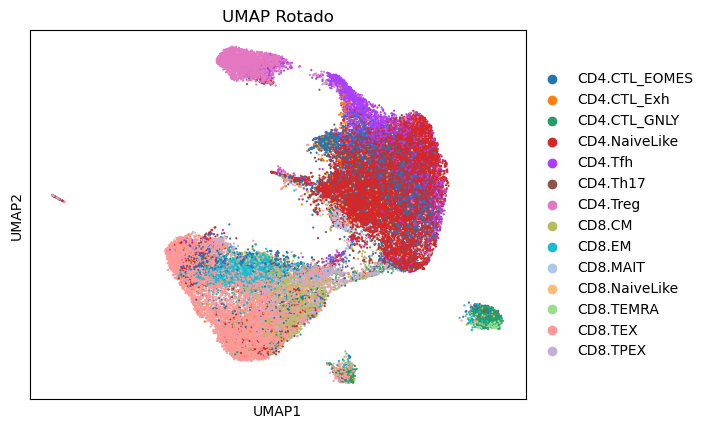

In [15]:
# Graficar el UMAP después de la rotación
sc.pl.umap(adata_gex, color="ATLAS_TIL_KNN", title="UMAP Rotado", legend_loc="right margin", size=10)

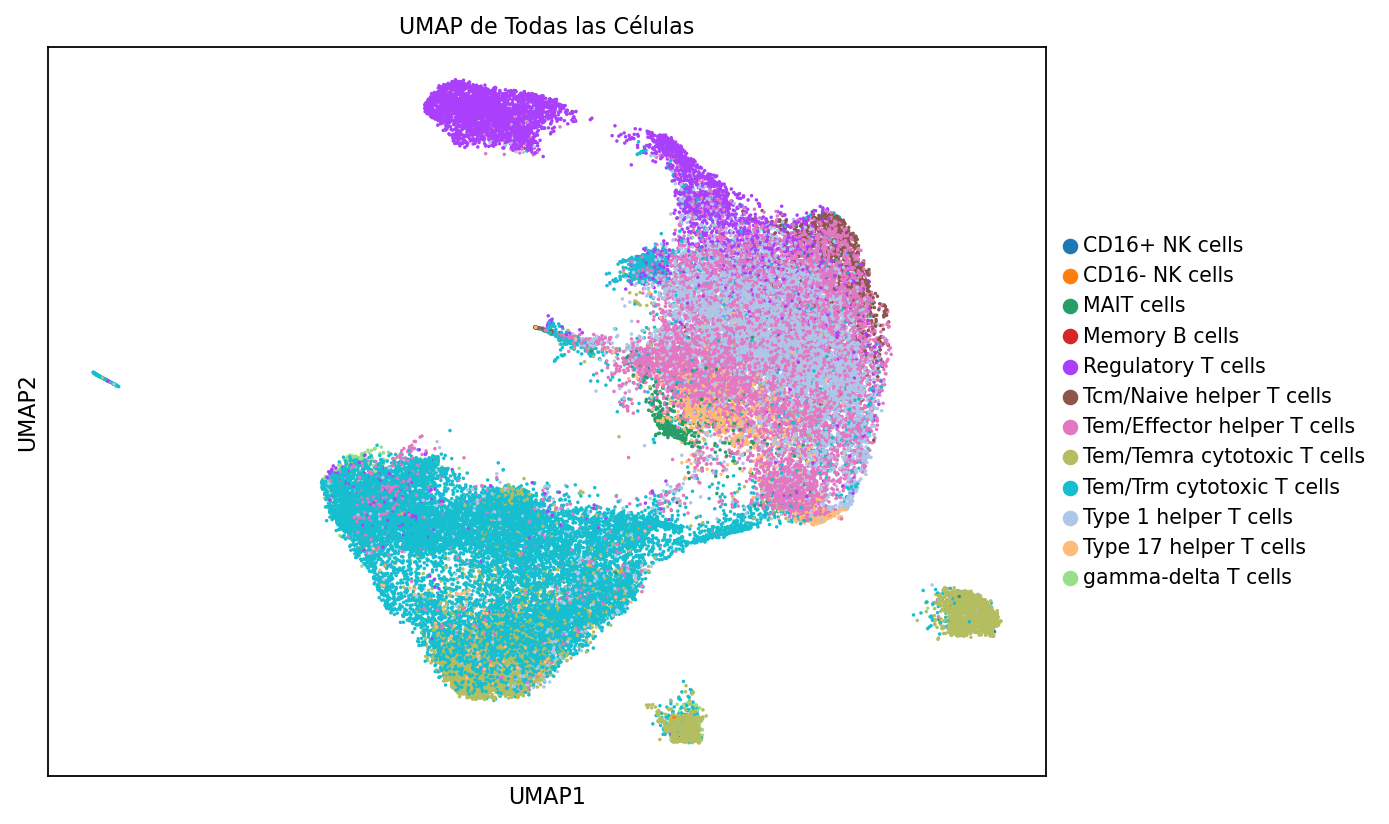

In [16]:
# Configurar el tamaño de la fuente y el tamaño de la figura
sc.set_figure_params(figsize=(8, 6), fontsize=10)
sc.pl.umap(adata_gex, color='Celltypist', title='UMAP de Todas las Células', legend_loc='right margin', size=10)

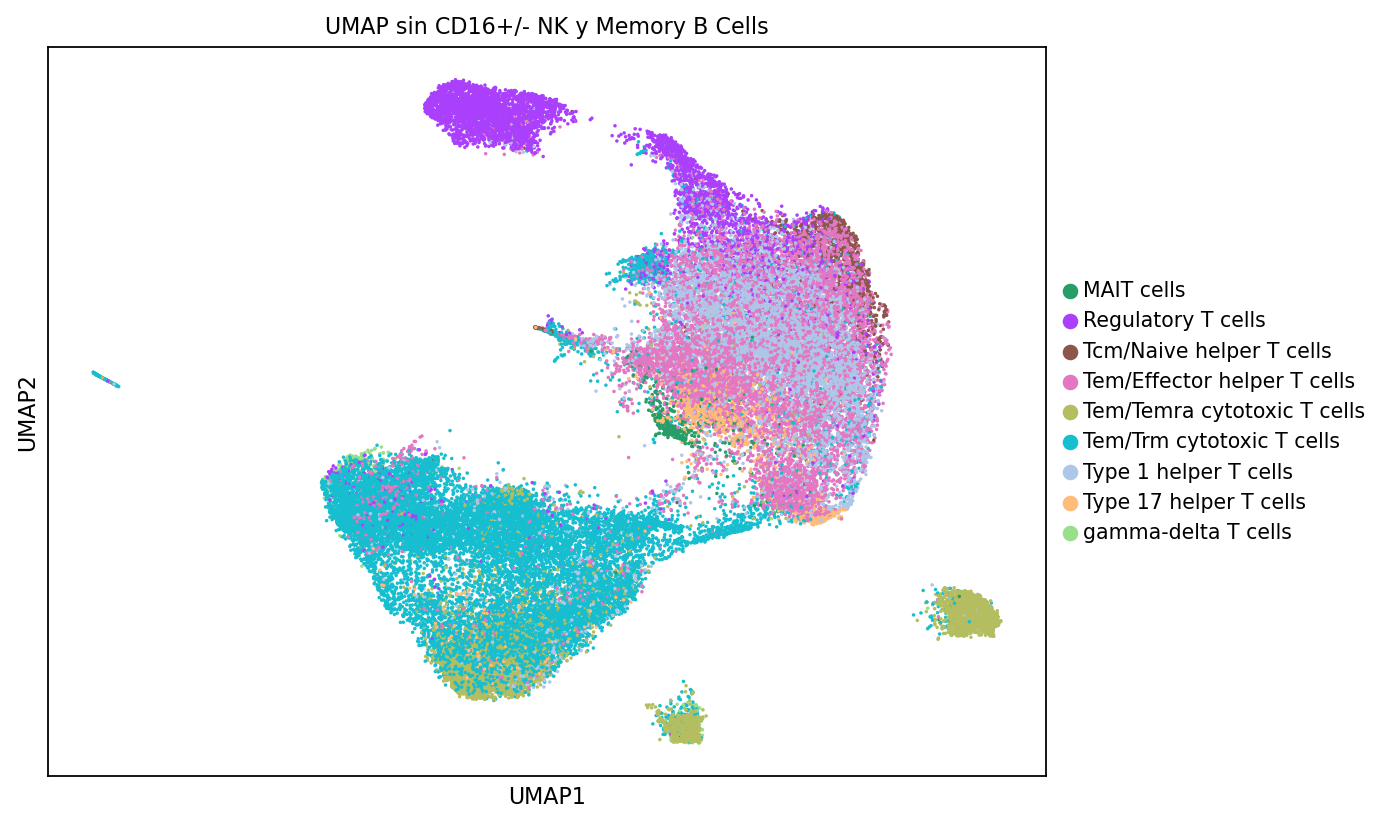

In [17]:
# Crear una copia del objeto sin modificar el original
adata_filtered = adata_gex[~adata_gex.obs['Celltypist'].isin(['CD16+ NK cells', 'CD16- NK cells', 'Memory B cells'])].copy()

# Generar el UMAP sin estas categorías en la leyenda
sc.pl.umap(adata_filtered, color='Celltypist', title='UMAP sin CD16+/- NK y Memory B Cells', legend_loc='right margin', size=10)

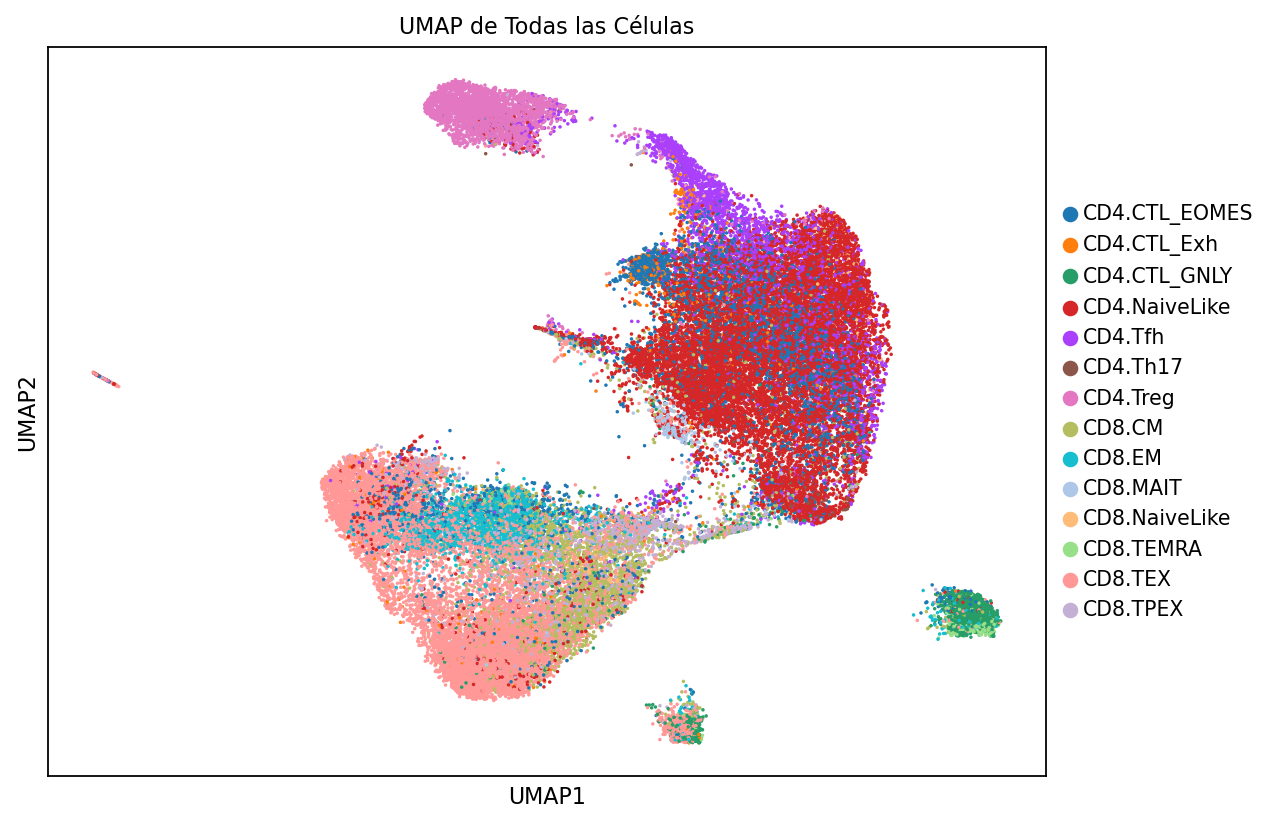

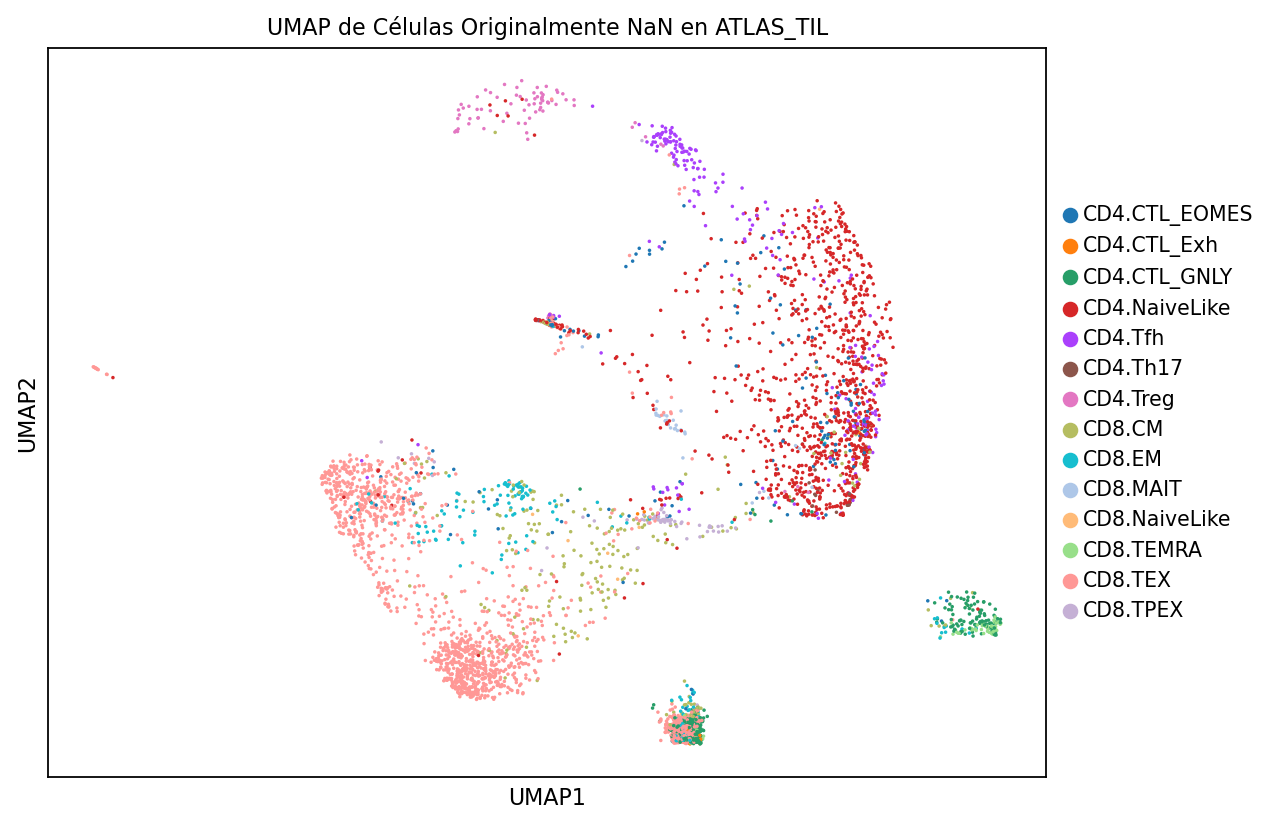

In [18]:
# Configurar el tamaño de la fuente y el tamaño de la figura
sc.set_figure_params(figsize=(8, 6), fontsize=10)

# UMAP completo con las etiquetas de ATLAS_TIL_KNN
sc.pl.umap(adata_gex, color='ATLAS_TIL_KNN', title='UMAP de Todas las Células', legend_loc='right margin', size=10)

# Filtrar las células que originalmente eran NaN en 'ATLAS_TIL'
nan_cells = adata_gex[adata_gex.obs['ATLAS_TIL'].isna()]

# UMAP solo para las células que eran NaN
sc.pl.umap(nan_cells, color='ATLAS_TIL_KNN', title='UMAP de Células Originalmente NaN en ATLAS_TIL', legend_loc='right margin', size=10)

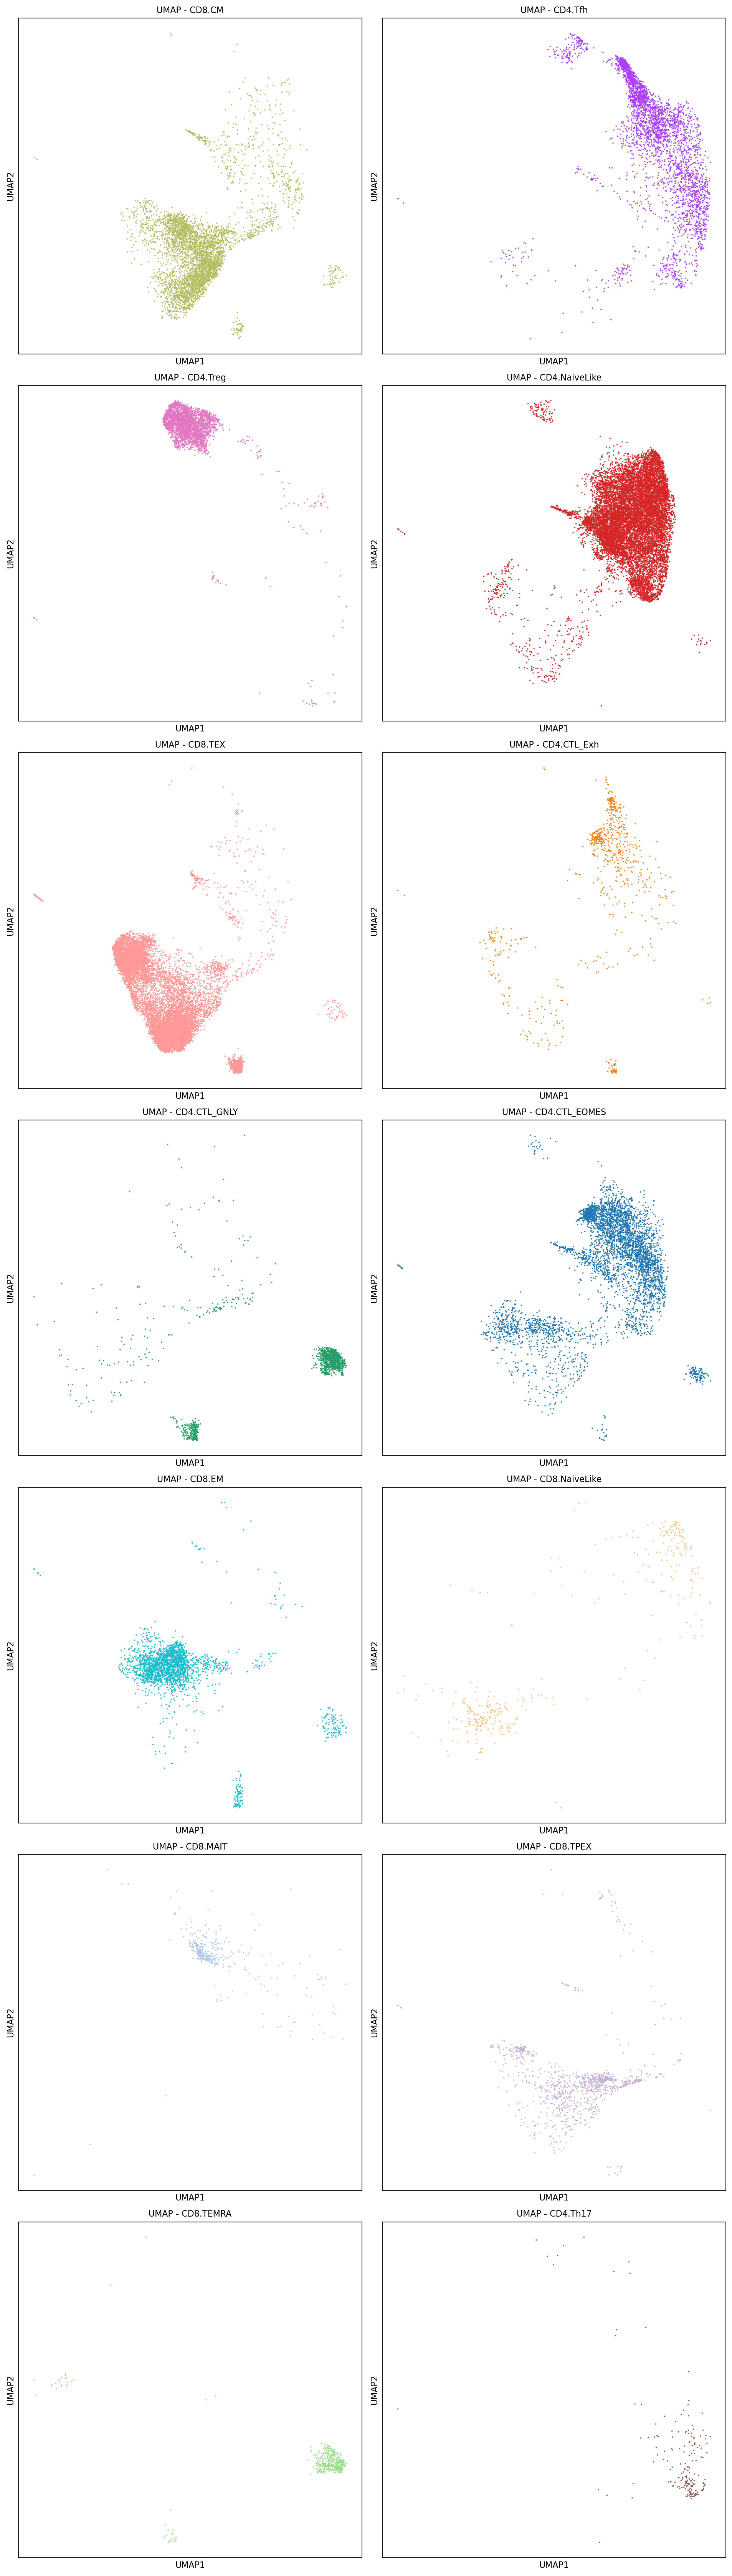

In [39]:
# Obtener los tipos de células únicos
cell_types = adata_gex.obs['ATLAS_TIL_KNN'].unique()

# Configurar los parámetros de la figura
sc.set_figure_params(figsize=(6, 5), fontsize=10)

# Definir el número de filas y columnas
n_cols = 2
n_rows = (len(cell_types) + 1) // n_cols  # Asegura que haya suficientes filas

# Crear la figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 6))  # Tamaño ajustado para 2 columnas

# Aplanar los ejes para iterar fácilmente
axes = axes.flatten()

# Generar un UMAP para cada tipo de célula
for i, cell_type in enumerate(cell_types):
    sc.pl.umap(
        adata_gex[adata_gex.obs['ATLAS_TIL_KNN'] == cell_type],
        color='ATLAS_TIL_KNN',
        title=f'UMAP - {cell_type}',
        legend_loc='none',
        size=10,
        ax=axes[i],  # Dibujar en el subgráfico correspondiente
        show=False
    )

# Ocultar los subgráficos vacíos si hay alguno
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

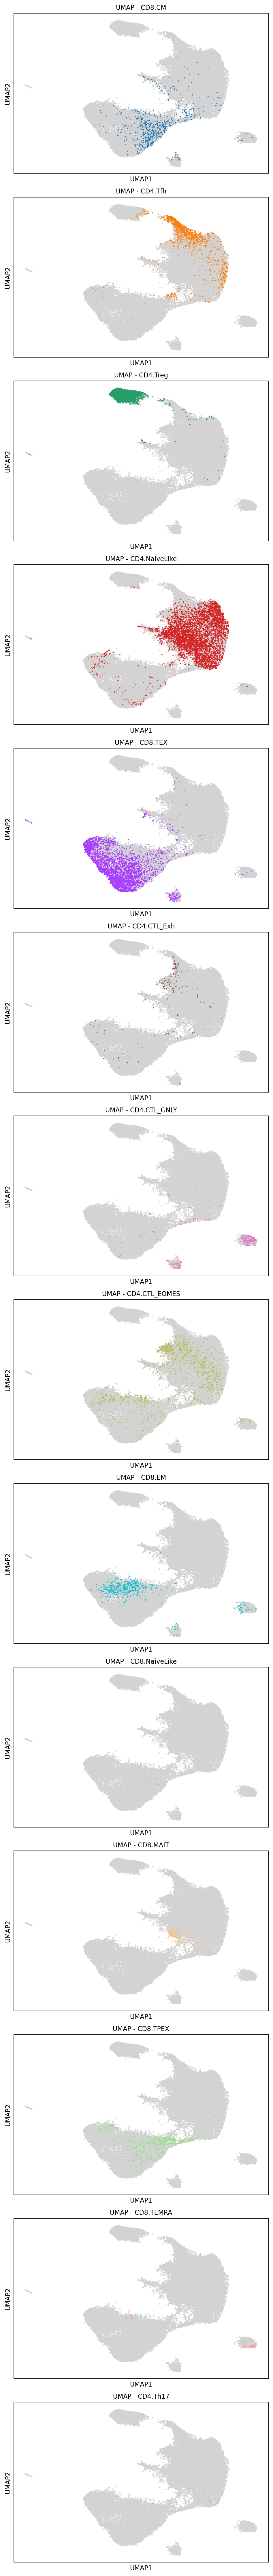

In [44]:
import scanpy as sc
import matplotlib.pyplot as plt

# Obtener los tipos de células únicos y los colores previamente usados
cell_types = adata_gex.obs['ATLAS_TIL_KNN'].unique()
original_palette = sc.pl.palettes.default_20[:len(cell_types)]  # Mantiene la paleta original
palette = dict(zip(cell_types, original_palette))  # Asigna los colores a cada tipo de célula

# Configurar los parámetros de la figura
sc.set_figure_params(figsize=(6, 5), fontsize=10)

# Definir el número de filas (una por tipo de célula)
n_rows = len(cell_types)
n_cols = 1  # Una sola columna

# Crear la figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, n_rows * 4))  # Ajustar tamaño vertical

# Asegurar que axes sea iterable incluso si es un solo gráfico
if n_rows == 1:
    axes = [axes]

# Generar un UMAP para cada tipo de célula con el fondo en gris claro
for i, cell_type in enumerate(cell_types):
    # Crear una nueva columna con la categoría para resaltar en color
    adata_gex.obs["highlight"] = "Other"
    adata_gex.obs.loc[adata_gex.obs['ATLAS_TIL_KNN'] == cell_type, "highlight"] = cell_type

    # Mantener los mismos colores que en la visualización original, con fondo gris más claro
    palette_with_grey = {"Other": "#D3D3D3", cell_type: palette[cell_type]}  # Gris más claro

    # Ajustar tamaño del punto para asegurar visibilidad
    sc.pl.umap(
        adata_gex,
        color="highlight",
        palette=palette_with_grey,
        title=f'UMAP - {cell_type}',
        legend_loc=None,
        size=15,  # Tamaño mayor para mejor visibilidad
        ax=axes[i],  # Dibujar en el subgráfico correspondiente
        show=False
    )

plt.tight_layout()
plt.show()




In [ ]:
# Filtrar los tipos de células no deseados
excluded_types = ['CD16+ NK cells', 'CD16- NK cells', 'Memory B cells']
adata_filtered = adata_gex[~adata_gex.obs['Celltypist'].isin(excluded_types)].copy()

# Obtener los tipos de células únicos después de la exclusión
cell_types = adata_filtered.obs['Celltypist'].unique()

# Configurar los parámetros de la figura
sc.set_figure_params(figsize=(6, 5), fontsize=10)

# Definir el número de filas y columnas
n_cols = 2
n_rows = (len(cell_types) + 1) // n_cols  # Asegura suficientes filas

# Crear la figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 6))  # Tamaño ajustado para 2 columnas

# Aplanar los ejes para iterar fácilmente
axes = axes.flatten()

# Generar un UMAP para cada tipo de célula
for i, cell_type in enumerate(cell_types):
    sc.pl.umap(
        adata_filtered[adata_filtered.obs['Celltypist'] == cell_type],
        color='Celltypist',
        title=f'UMAP - {cell_type}',
        legend_loc='none',
        size=10,
        ax=axes[i],  # Dibujar en el subgráfico correspondiente
        show=False
    )

# Ocultar los subgráficos vacíos si hay alguno
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [31]:
# Contar la cantidad de células en cada categoría de ATLAS_TIL_KNN
gamma_delta_counts = gamma_delta_rows['ATLAS_TIL_KNN'].value_counts()

# Calcular el porcentaje
gamma_delta_percent = (gamma_delta_counts / gamma_delta_counts.sum()) * 100

# Crear un DataFrame con los resultados
gamma_delta_summary = pd.DataFrame({'ATLAS_TIL_KNN': gamma_delta_counts.index, 'Percentage': gamma_delta_percent.values})

# Mostrar la tabla ordenada por porcentaje
gamma_delta_summary.sort_values(by="Percentage", ascending=False, inplace=True)
print(gamma_delta_summary)


    ATLAS_TIL_KNN  Percentage
0         CD8.TEX   64.750378
1    CD4.CTL_GNLY   15.733737
2     CD4.CTL_Exh    6.656581
3          CD8.EM    4.236006
4          CD8.CM    3.479576
5        CD8.TPEX    2.874433
6       CD8.TEMRA    1.059002
7   CD4.CTL_EOMES    0.756430
8   CD4.NaiveLike    0.151286
9         CD4.Tfh    0.151286
10  CD8.NaiveLike    0.151286
11       CD4.Th17    0.000000
12       CD8.MAIT    0.000000
13       CD4.Treg    0.000000


Quitamos las gamma-delta T cells y las sustituimos por  Tem/Temra cytotoxic T cells ya que se solapan tanto en UMAP como en ATLAS_TIL_KNN


In [21]:
adata_gex

AnnData object with n_obs × n_vars = 49043 × 23209
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'prediction', 'doublet', 'doublet_filtered', 'Sample', 'n_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'ATLAS_TIL', 'ATLAS_TIL_score', 'Celltypist', 'Celltypist_score', 'ATLAS_TIL_KNN'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'log1p', 'neighbors', 'ATLAS_TIL_colors', 'ATLAS_TIL_KNN_colors', 'Celltypist_colors'
    obsm: 'X_pca_harmony', 'X_umap'
    layers: 'counts_soupx_crude', 'original_counts'
    obsp: 'connectivities', 'distances'

In [22]:
# Copiar columnas relevantes
columns_to_copy = ['ATLAS_TIL_KNN', 'ATLAS_TIL_score', 'Celltypist', 'Celltypist_score']
for col in columns_to_copy:
    if col in adata_gex.obs.columns:
        mdata.mod['gex'].obs[col] = adata_gex.obs[col]

In [23]:
# Guardar el MuData actualizado
output_path = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/05_datos_integrados/mudata_harmony_conTCR_KNN.h5mu"
mdata.write(output_path)